# SENTIMENT ANALYSIS ON AMAZON FINE FOOD REVIEWS

## Import Required Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

## Load Dataset

In [ ]:
df = pd.read_csv("Reviews.csv")

# Display first five rows of the dataframe
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Explore Dataset

In [ ]:
# find dataframe shape (rows, columns)
print("Shape of Dataset:", df.shape)

# list all columns in the dataframe
print("\nColumns:", df.columns.tolist())

# check for missing values in each column
print("\nMissing Values:\n", df.isnull().sum())

Shape of Dataset: (568454, 10)

Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Missing Values:
 Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


### Basic information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Review Score Distribution

C:\Users\HP\AppData\Local\Temp\ipykernel_34620\2380837616.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Score', data=df, palette='magma')


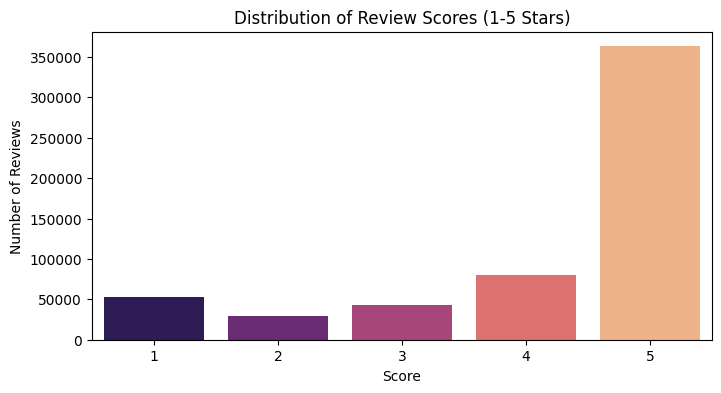

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x='Score', data=df, palette='magma')
plt.title("Distribution of Review Scores (1-5 Stars)")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

## Average Helpfulness by Score

C:\Users\HP\AppData\Local\Temp\ipykernel_34620\1509702611.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Helpfulness_Ratio', data=avg_help, palette='viridis')


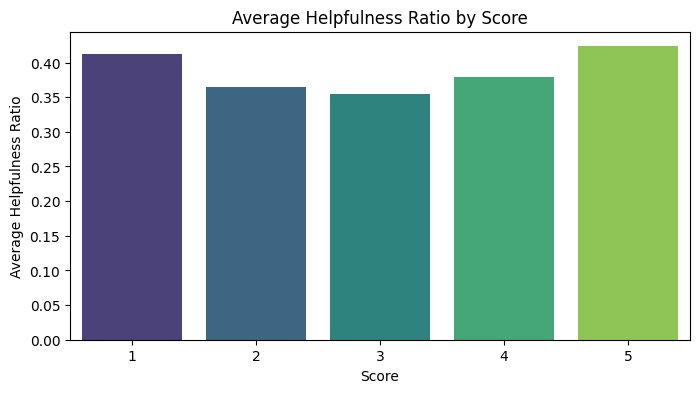

In [7]:
df['Helpfulness_Ratio'] = np.where(df['HelpfulnessDenominator'] != 0,
                                   df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
                                   0)

avg_help = df.groupby('Score')['Helpfulness_Ratio'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x='Score', y='Helpfulness_Ratio', data=avg_help, palette='viridis')
plt.title("Average Helpfulness Ratio by Score")
plt.ylabel("Average Helpfulness Ratio")
plt.show()

## Convert Time to Year (for Trend)

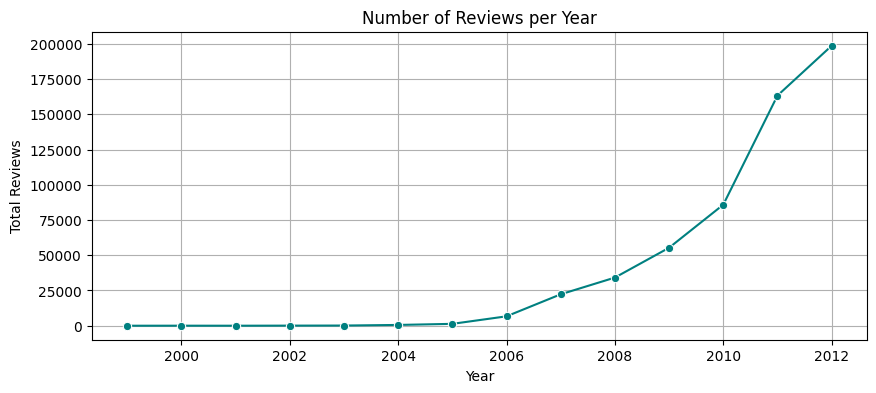

In [8]:
df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

yearly_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', color='teal')
plt.title("Number of Reviews per Year")
plt.xlabel("Year")
plt.ylabel("Total Reviews")
plt.grid(True)
plt.show()

## Top 10 Most Reviewed Products

C:\Users\HP\AppData\Local\Temp\ipykernel_34620\1713753298.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette='cool')


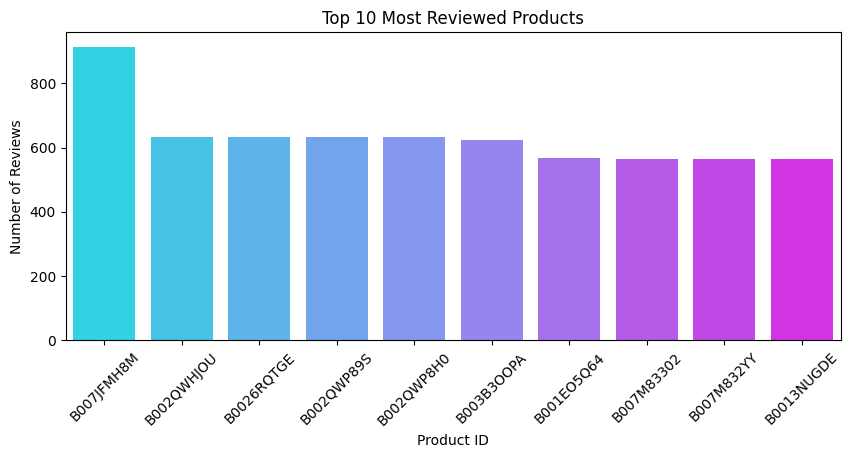

In [9]:
top_products = df['ProductId'].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=top_products.index, y=top_products.values, palette='cool')
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Product ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

## Top Words in Review Summaries (WordCloud)

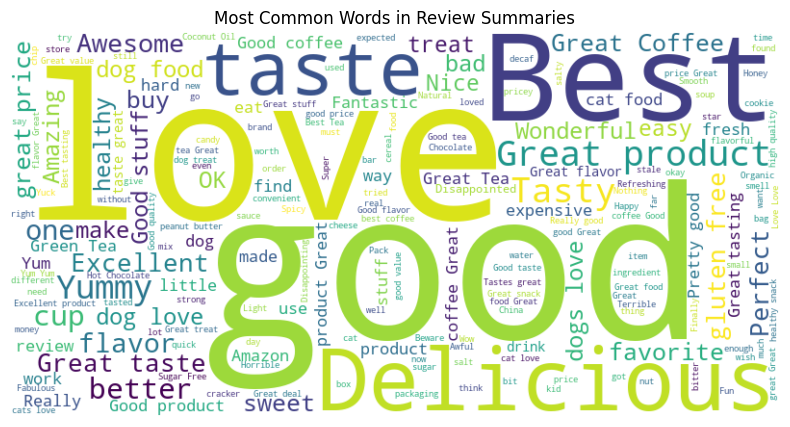

In [10]:
text_data = " ".join(review for review in df['Summary'].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white",
                      width=800, height=400).generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Review Summaries")
plt.show()

## Keep Only Useful Columns

In [11]:
df = df[['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
         'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']]

# Drop rows with missing Text or Score
df = df.dropna(subset=['Text', 'Score'])
df = df.reset_index(drop=True)

## Convert Score to Sentiment

In [12]:
# Score 1-2 → Negative | 3 → Neutral | 4-5 → Positive

def get_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['Sentiment'] = df['Score'].apply(get_sentiment)

# Optional: Remove neutral reviews for binary classification
df = df[df['Sentiment'] != 'neutral']

print("\nSentiment Distribution:")
print(df['Sentiment'].value_counts())


Sentiment Distribution:
Sentiment
positive    443777
negative     82037
Name: count, dtype: int64


## Clean Text Data

In [13]:
def clean_text(text):
    # convert text to lowercase
    text = text.lower()

    # remove links
    text = re.sub(r"http\S+", "", text)            

    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)              

    # keep only letters
    text = re.sub(r"[^a-z\s]", "", text)           

    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()       
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

## Exploratory Data Analysis (EDA)

C:\Users\HP\AppData\Local\Temp\ipykernel_34620\604739408.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='mako')


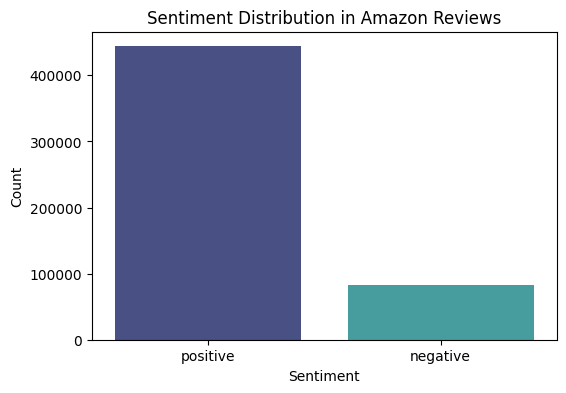


Average Helpfulness Ratio by Sentiment:
Sentiment
negative    0.395239
positive    0.415249
Name: Helpfulness_Ratio, dtype: float64


In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='mako')
plt.title("Sentiment Distribution in Amazon Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Average helpfulness ratio (just for understanding)
df['Helpfulness_Ratio'] = np.where(df['HelpfulnessDenominator'] != 0,
                                   df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'],
                                   0)

print("\nAverage Helpfulness Ratio by Sentiment:")
print(df.groupby('Sentiment')['Helpfulness_Ratio'].mean())

## Split Data

In [15]:
X = df['Cleaned_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\HP\AppData\Local\Temp\ipykernel_34620\3246860558.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Helpfulness_Ratio', data=df, palette='magma')


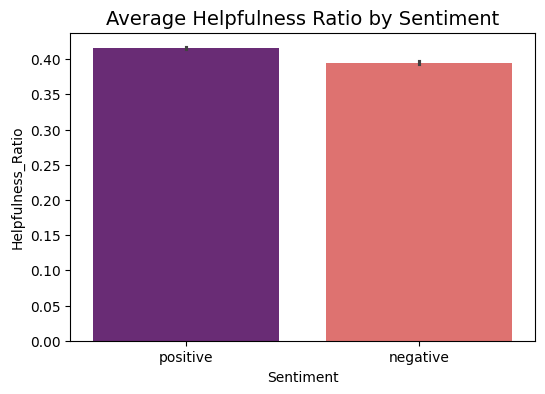

In [16]:
df['Helpfulness_Ratio'] = np.where(df['HelpfulnessDenominator'] != 0,
                                   df['HelpfulnessNumerator']/df['HelpfulnessDenominator'], 0)

plt.figure(figsize=(6,4))
sns.barplot(x='Sentiment', y='Helpfulness_Ratio', data=df, palette='magma')
plt.title("Average Helpfulness Ratio by Sentiment", fontsize=14)
plt.show()

## Vectorize Text using TF-IDF

In [17]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Model Training (Logistic Regression)

In [26]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Artificial Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

results = {}

## Train and Evaluate Each Model

## Logistic Regression

In [ ]:
lr_model = models["Logistic Regression"]
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", round(lr_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 94.1 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.74      0.80     16379
    positive       0.95      0.98      0.97     88784

    accuracy                           0.94    105163
   macro avg       0.91      0.86      0.88    105163
weighted avg       0.94      0.94      0.94    105163



## K-Nearest Neighbors (KNN)

In [31]:
knn_model = models["K-Nearest Neighbors"]
knn_model.fit(X_train_tfidf, y_train)

y_pred_knn = knn_model.predict(X_test_tfidf)
knn_acc = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy:", round(knn_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 88.05 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.97      0.24      0.39     16379
    positive       0.88      1.00      0.93     88784

    accuracy                           0.88    105163
   macro avg       0.92      0.62      0.66    105163
weighted avg       0.89      0.88      0.85    105163



## Decision Tree

In [32]:
dt_model = models["Decision Tree"]
dt_model.fit(X_train_tfidf, y_train)

y_pred_dt = dt_model.predict(X_test_tfidf)
dt_acc = accuracy_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", round(dt_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 90.88 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.70      0.71     16379
    positive       0.95      0.95      0.95     88784

    accuracy                           0.91    105163
   macro avg       0.83      0.83      0.83    105163
weighted avg       0.91      0.91      0.91    105163



## Naive Bayes

In [33]:
nb_model = models["Naive Bayes"]
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes Accuracy:", round(nb_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 89.65 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.37      0.53     16379
    positive       0.90      0.99      0.94     88784

    accuracy                           0.90    105163
   macro avg       0.90      0.68      0.74    105163
weighted avg       0.90      0.90      0.88    105163



## Random Forest

In [34]:
rf_model = models["Random Forest"]
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", round(rf_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 93.82 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.63      0.76     16379
    positive       0.94      1.00      0.96     88784

    accuracy                           0.94    105163
   macro avg       0.95      0.81      0.86    105163
weighted avg       0.94      0.94      0.93    105163



## Artificial Neural Network (MLP)

In [35]:
ann_model = models["Artificial Neural Network"]
ann_model.fit(X_train_tfidf, y_train)

y_pred_ann = ann_model.predict(X_test_tfidf)
ann_acc = accuracy_score(y_test, y_pred_ann)

print("Artificial Neural Network Accuracy:", round(ann_acc * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ann))

c:\Users\HP\Documents\4th semester\Programing For AI\Project\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Artificial Neural Network Accuracy: 96.02 %

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.86      0.87     16379
    positive       0.97      0.98      0.98     88784

    accuracy                           0.96    105163
   macro avg       0.93      0.92      0.92    105163
weighted avg       0.96      0.96      0.96    105163



## Display Best Model

In [36]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print("\n==============================================")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {round(results[best_model_name]*100, 2)}%")
print("==============================================\n")

# Detailed Classification Report for the Best Model
y_pred_best = best_model.predict(X_test_tfidf)
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Best Model: Logistic Regression
Accuracy: 94.1%

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.74      0.80     16379
    positive       0.95      0.98      0.97     88784

    accuracy                           0.94    105163
   macro avg       0.91      0.86      0.88    105163
weighted avg       0.94      0.94      0.94    105163



C:\Users\HP\AppData\Local\Temp\ipykernel_34620\2227351406.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


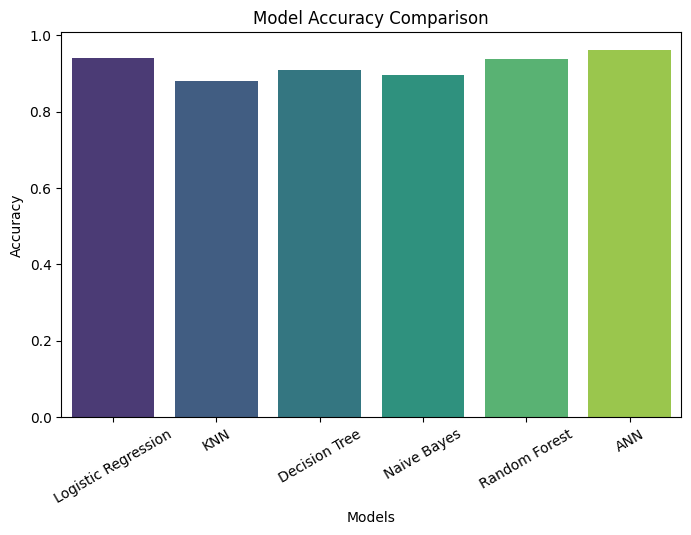

In [37]:
results = {
    "Logistic Regression": lr_acc,
    "KNN": knn_acc,
    "Decision Tree": dt_acc,
    "Naive Bayes": nb_acc,
    "Random Forest": rf_acc,
    "ANN": ann_acc
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.xticks(rotation=30)
plt.show()

## Evaluation Metrix (Best Model)

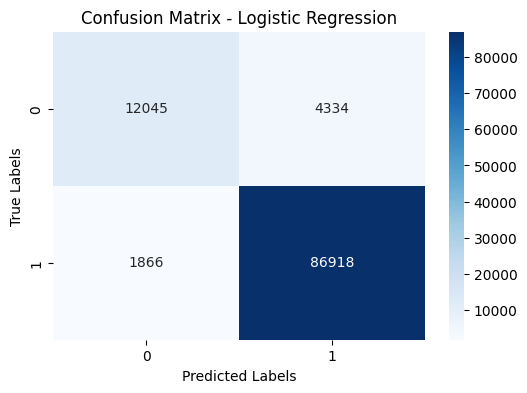

In [40]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Save Model and Vectorizer

In [39]:
with open("best_sentiment_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

with open("tfidf_vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

print(f"\nBest model ('{best_model_name}') and TF-IDF vectorizer saved successfully!")


Best model ('Logistic Regression') and TF-IDF vectorizer saved successfully!
